In [1]:
import jax
import jax.numpy as np
import os
import copy

os.environ["CHALK_JAX"] = "1"
from chalk import *
from colour import Color
from IPython.display import HTML
import jax
import optax
import chalk.transform
import numpy as onp
import glob
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
import random


eps = 1e-3

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# A Tour of Differentiable Rasterization

By [Sasha Rush](https://x.com/srush_nlp) - [Notebook](https://github.com/srush/diffRast/)

Built with [Chalk](https://github.com/chalk-diagrams/) developed with [Dan Oneață](https://doneata.bitbucket.io/) 

Based on 

* [Differentiable Vector Graphics Rasterization for Editing and Learning](https://cseweb.ucsd.edu/~tzli/diffvg/)
* [Efficient GPU Path Rendering Using Scanline Rasterization](http://kunzhou.net/zjugaps/pathrendering/GPUpathrendering.pdf)
* [Monoids: Theme and Variations](https://core.ac.uk/download/pdf/76383233.pdf)
* [JAX: High-Performance Array Computing](https://jax.readthedocs.io/en/latest/)

Given a program that produces a vector representation of an image (think SVG), *rasterization* turns it into
a pixel representation (think PNG). If we have a target image, we can see how close we got.

$$\begin{align*}
  \text{vector} &= \text{program}(x) \\
  \text{image} &= \text{rasterizer}(\text{vector}) \\
  {\cal L}(\text{image}, \text{target}) &= \| \text{image} - \text{target} \| \\
\end{align*}$$

Unfortunately this process is not inherently differentiable. Moreover, it doesn't easily run in modern
deep learning frameworks like Jax or PyTorch. The goal of this post is to walk through this calculation.

$$\text{Goal:}   \frac{d {\cal L}}{dx} = \frac{d {\cal L}}{d\ \text{image}} \frac{d\ {\text{image}}}{d\ \text{vector}} \frac{d\ \text{vector}}{dx}$$


To make this all more tangible, say we have a target image and a program
that can draw ellipses based on their locations, size, and rotation. Differentiable rasterization would let us
use gradient descent to adjust the parameters $x$ to match the image.

In [2]:
HTML(
    """

<script src="https://unpkg.com/freezeframe/dist/freezeframe.min.js"></script>

<div><img src="smiley3.webp" width="40%"><div style="width:40%; float:right"><img class="freezeframe" id="smiley" src="smiley1.gif" width="40%"></div></div>
<script>
new Freezeframe({selector: '#smiley', overlay:true});
</script>

"""
)

This blog is not really about computer graphic (I don't know much about computer graphics). #
The goal is to explore *differentiable programming* in realistic settings.
If autodiff + vectorization is the future, then it is important to be able to write hard programs
in a differentiable style (beyond just another Transformer).

The blog is in 5 parts. It assumes no graphics knowledge, but does use a lot of Jax/NumPy tricks. The target audience is someone with a lot of ML experience who wants to branch out into some more complex uses of derivatives. 

* [Section 1: Transforms, Arcs, Paths](#section-1-transforms-arcs-paths)
* [Section 2: Jax x Graphics](#section-2-jax-x-graphics)
* [Section 3: Tracing](#section-3-tracing)
* [Section 4: Vector -> Image](#section-4-vector---image)
* [Section 5: Differentiable Rasterization](#section-5-differentiable-rasterization)


In [3]:
import imageio.v3 as imageio
import base64

# import PIL
ff_id = 0


def animate_out(images, steps=36, rate=20, **kwargs):
    global ff_id
    # with imageio.get_writer("/tmp/out.gif", loop=0, fps=rate, **kwargs) as writer:
    writer = []
    for im in images:
        image = imageio.imread(im)
        # image = PIL.Image.open(im)
        writer.append(image)
    # writer[0].save('/tmp/out.gif', save_all=True, append_images=writer,
    #               loop=0, duration=200, transparency=0, disposal=0)
    ff_id += 1

    imageio.imwrite(f"animations/out.{ff_id}.gif", writer, loop=0, fps=rate, **kwargs)

    # imageio.mimsave(
    # base = base64.b64encode(open("/tmp/out.gif", 'br').read()).decode('ascii')
    return HTML(
        f"""
  <div style="text-align:center;"><div style="width:70%; margin:auto;"><img src="animations/out.{ff_id}.gif" id='ff{ff_id}'></div></div>
<script>
new Freezeframe({{
  selector: '#ff{ff_id}'  
}});
</script>



  """
    )


grid = rectangle(4, 4).fill_color("white").line_width(0) + (
    make_path([(-2, 0), (2, 0)]) + make_path([(0, -2), (0, 2)])
).line_color("grey").line_width(1)
hgrid = rectangle(10, 10).fill_color("white").line_width(0).align_tl()
bgrid = rectangle(100, 100).fill_color("white").line_width(0).align_tl()


def animate(fn1, steps=36, rate=20, grid=grid, lw=True, **kwargs):
    os.system("rm /tmp/render*.png /tmp/out.gif 2> /dev/null")
    images = []

    def fn(t):
        im = fn1(t / steps)
        if isinstance(im, tuple):
            im, extra = im
        else:
            extra = empty()

        return hcat(
            [grid + (im.with_envelope(empty()).line_width(2 if lw else None)), extra],
            0.4,
        ).layout(500)

    if chalk.transform.JAX_MODE:
        fn = jax.jit(fn)

    for t in range(1, steps):
        out, h, w = fn(t)
        p = f"/tmp/render.{t:03d}.png"
        chalk.backend.cairo.prims_to_file(out, p, h, w)
        images.append(p)
    return animate_out(images)


@jax.vmap
def inner(j, i, a):
    op = np.minimum(1.0, np.abs(a))
    return (
        rectangle(0.75, 0.75, 0.1)
        .center_xy()
        .translate(i, j)
        .fill_color(
            op * np.where(a > 0, to_color("blue"), to_color("red")) + (1 - op) * 1
        )
        .line_width(0)
    )


@jax.jit
def show_affine(aff):
    out = inner(np.arange(9) // 3, np.arange(9) % 3, aff.reshape(-1))
    return out.center_xy().scale(
        0.5
    )


@jax.jit
def show_color(color):
    out = inner(np.arange(3), np.zeros(3), color.reshape(-1))
    return out.center_xy().scale(
        0.5
    )





def show_arc(a):
    a = copy.deepcopy(a)
    angles = a.segments.angles
    angles = angles.at[0, 1].set(360)
    a.segments.angles = angles
    return a

## Section 1: Transforms, Arcs, Paths

This section is about vector graphics and linear algebra. 
We want to be able to represent a vector graphic as a function of parameters using matrices.

$$\begin{align*}
  \text{vector} &= \text{program}(x) \\
\end{align*}
$$

To arrive here, we need to convince ourselves that this process is
fully differentiable and expressible in NumPy. This will also
allow us to introduce the basic primitives of vector graphics.

We start with a *transform*. This is an affine function of a 2D point.
Given a point $(x, y)$, we produce a point $(x', y')$
where $x' = a x + b y + c$ and $y' = d x + e y + f$.
This will allow us to mathematically represent intuitive
notions of scaling, rotation, and translation.

We can represent these affine functions as a 3x3 matrices.
$$\begin{align*}
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} &= \begin{bmatrix} a & b & c \\ d & e & f \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} \\
\end{align*}$$
The key trick being to represent 2D points in 3D with a fixed 1 in the last position. We can the apply transforms to points, lines, shapes, or other transforms etc.
As these are standard matrix operations, they naturally have meaningful derivatives, which autodiff can provide for us.


We start by applying them to a simple line.

In [4]:
line = arc_seg(V2(1, 1), 1e-3).stroke()

Translations have an identity scaling and use the last column for the offet. We show the current transform matrix on the right side. 

In [5]:
def translate(t: float):
    "t is a float between 0 and 1"
    affine = tx.translation(V2(0, t))
    return line.apply_transform(affine), show_affine(affine)


animate(translate)

Scaling transforms use the top left diagonal of the matrix. 


In [6]:
def scale(t):
    affine = tx.scale(t)
    return line.apply_transform(affine), show_affine(affine)


animate(scale)

Rotation transforms uses the off-diagonal.


In [7]:
def rotate(t):
    affine = tx.rotation(t * 2 * np.pi)
    return line.apply_transform(affine), show_affine(affine)


animate(rotate)

In our little library we use `+` to represent composition of vector diagrams.
Here two lines are combined in a single image. The first
is rotated and the second is rotated in the opposite direction
using the matrix inverse of the transform matrix.


In [8]:
def cat(t):
    affine = tx.rotation(t * 2 * np.pi)
    affine2 = tx.inv(affine)
    return line.apply_transform(affine) + line.apply_transform(affine2), show_affine(
        affine
    ) | show_affine(affine2)


animate(cat)

Colors are also represented mathematically. We use simple RGB vectors.

$$ \text{color} = \begin{bmatrix} r \\ g \\ b \end{bmatrix}$$


In [9]:
def color_line(t):
    # Helper function for standard colors. 
    red = to_color("red")
    blue = to_color("blue")
    color = t * red + (1 - t) * blue
    return line.line_color(color), show_color(color)


animate(color_line)

For simplicity, the only function we provide is an *arc*.
Arcs are created by providing a vector offset and the bend height.
Note that lines are just arcs with a bend near 0.


In [10]:
def arc(t):
    # End position of the arc.
    v = V2(1, 0)
    # Create an arc from (0, 0) to v with bend t.
    a_s = arc_seg(v, t)
    # Stroke turns an arc into a vector diagram. 
    return a_s.stroke()


animate(arc)

Internally arcs are circles clipped between two angles. 
We can do this calculation with some (differentiable) 
[high-school trigonometry](https://observablehq.com/@sarah37/arcs-between-two-points).


Here is what these arcs look like by composing the arc and the
internal circle representation.


In [11]:
def arc(t):
    v = V2(1, 0)
    a_s = arc_seg(v, t)
    return a_s.stroke().line_width(2) + show_arc(a_s).stroke().line_width(0.1)


animate(arc, lw=False)

We can *chain* arcs together before stroking them to vector diagrams.
We agin use `+` operator for chaining before closing the path.  

(Note that `+` is used both for chaining and composition. This is 
because both of [monoids](https://core.ac.uk/download/pdf/76383233.pdf)
and so they share internal structure. This can be point of confusion though.)

Filled paths made with chained arcs will be the core element we work with.

In [12]:
def closed(t):
    v = V2(1, 0)
    return (arc_seg(v, t) + arc_seg(-v, -0.2)).close().stroke()


animate(closed)

We conclude with a circle function. 

1. Create a path by chaining two arcs together.
2. Create a transform that centers the circle, scales it, and moves it.
3. Apply the transform to the circle. 

In [13]:
def circle_at(p, r):
    "Draw a circle at `p` with radius `r`"
    # Draw a circle with radius 1 centered at (0, 1)
    circle = (arc_seg(V2(0, 2), 1) + arc_seg(V2(0, -2), 1)).close().stroke()
    # Move the circle to p and scale to radius r
    affine = tx.translation(p) @ tx.scale(r) @ tx.translation(V2(0, -1))
    return circle.apply_transform(affine)


def draw_circle(t):
    return circle_at(t, t)


animate(draw_circle)

## Section 2: Jax x Graphics

This section is about Jax, a library for differentiable programming.
Jax is built on top of NumPy so it works directly with NumPy arrays
you probably are used to. Basically python dataclass that is 
made up of NumPy arrays can be utilized withing the Jax framework.
The key thing to note is that our vector diagrams are 
[Jax PyTrees](https://jax.readthedocs.io/en/latest/pytrees.html).

The downside of Jax is that we will not be able to use a lot of standard python functions, and
will have to write everything in a strict functional style without `if's`. This will make
later things harder.

But there are upsides. In this section we will discuss the use of 
*vmap*, which allows us to automatically vectorize functions, and *grad* 
which will allow us to compute derivatives are arbitrary functions.
# 
Let's start with [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html).
This function will allow us to easily create complex vector diagrams, 
by describing many different paths at once. For example
here we are using `vmap` to create 10 circles.

(Note from here on out we use simpler 
methods like `scale_x` instead of manually 
creating affine matrices. Hopefully they are self-explanatory)


In [14]:
def draw(t):
    @jax.vmap
    def multi(i):
        "Draw a circle with radius using `i`."
        return circle_at(P2(0, 0), (0.05 * i + t)).scale_x(1.2).fill_opacity(0)

    # Create 9 circles with i from 1 to 9.
    return multi(np.arange(1, 10))

animate(draw)

You might have noticed the code above for simple functions is kind of slow. 
Jax transforms take a little longer to startup, but they automatically 
let us scale to some very complex figures. Here we are creating 100 circles.


In [15]:
def draw(t):
    red = to_color("red")
    green = to_color("green")

    @jax.vmap
    def multi(i):
        i_s = i / 100
        s = (0.05 * i) / 2
        rot = tx.rotation(i * t + i)
        return (
            rectangle(s, s)
            .fill_color(i_s * red + (1 - i_s) * green)
            .line_width(0)
            .apply_transform(rot)
        )

    return multi(np.arange(100, 1, -1))


animate(draw, lw=False, steps=200, rate=5)

We can use vmap on multiple arguments simulataneously 
or even entire trees of parameters. Here is one more fun
example taking multiple arguments. 

In [16]:
T = 100


def multi(t):
    r, g = to_color("red"), to_color("green")

    @jax.vmap
    def draw(x, y):
        t2 = (x + y + t) % 1
        t2 = np.maximum(t2, 1 - t2)
        return (
            circle_at(P2(x, y), t2 / 10 - 0.2)
            .fill_color(t2 / 2 * r + 2 * (1 - t2) * g)
            .translate(-0.5, -0.5)
            .scale(2)
            .line_width(0)
        )

    return draw((np.arange(T) // 10) / 10, (np.arange(T) % 10) / 10)


animate(jax.jit(multi), steps=10, lw=False)

The other core benefit of having Jax is to be able to differentiate functions.
Since we are able to take derivatives of all our functions we can use gradient descent to
optimize for arbitrary properties. 

We'll introduce a function `opt` that uses [Adam](https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.adam) to
optimize and draw an arbitrary function. Our optimization 
uses unconstrained optimization with  
a starting point and a function `f`, and draws the
intermediate vector diagrams.  

$$\arg\min_{x} f(x)$$ 

There are more interesting optimizers we could apply here, 
but we'll keep it simple for now.  

In [17]:
Xs = []


def opt(x, fn, steps=100, verbose=False, save_every=1, rate=0.3, show=None):
    global Xs
    Xs = []
    fn = jax.jit(jax.value_and_grad(fn, has_aux=True))
    solver = optax.adam(learning_rate=rate)
    opt_state = solver.init(x)
    loss = []
    os.system("rm /tmp/test*.png 2> /dev/null")
    for j in range(steps):
        value, grad = fn(x)
        score, out = value
        loss.append(score)
        updates, opt_state = solver.update(grad, opt_state, x)
        x = optax.apply_updates(x, updates)
        if j % save_every == 0:
            if show is not None:
                out, h, w = show(x)
            else:
                out, h, w = out
            chalk.backend.cairo.prims_to_file(out, f"/tmp/test.{j:03d}.png", h, w)
        if verbose:
            print("Step:", j, score)
            Xs.append(x)
    #plt.plot(loss)
    images = sorted(glob.glob("/tmp/test.*.png"))
    return animate_out(images)

In [18]:
def L2(x):
    return (x * x).sum(-1)


def find_point(target, x):
    return L2(target - x).sum(), (
        grid
        + circle_at(target, 0.1).fill_color("red")
        + circle_at(x, 0.1).fill_color("blue")
    ).layout(500)


# Use partial to specify the target. Optimize over x.
opt(P2(0, 0), partial(find_point, P2(0.5, 0.5)), steps=100, rate=0.1)

The two aspects work well together.
A [force-directed graph](https://en.wikipedia.org/wiki/Force-directed_graph_drawing)
is a way to layout a graph in a visually pleasing way in 2D space. 
The approach for physical forces over the nodes and edges.

In this function we use three forces. A spring along edges, repulsion between
all nodes, and a weak gravity towards the center of the graph.



In [19]:
@jax.jit
def force_directed(x, edges, a=1 / 20, b=1 / 10, c=50, spring=0.04):
    size = x.shape[0]
    nodes = np.arange(size)
    # Colors for nodes
    color = np.stack([to_color(c) for c in Color("red").range_to("blue", size)])

    # Draw nodes and calculate node forces
    @jax.vmap
    def dots(p, i, color):
        d = circle(0.1).translate(p[0], p[1]).fill_color(color)
        return d, np.abs(x).sum()

    out, gravity = dots(x, np.arange(size), color)

    # Draw nodes and calculate edge forces
    @jax.vmap
    def connect(inp, out):
        a, b = x[inp], x[out]
        # `make_path`` is a helper around `seg`.
        return make_path([(a[0], a[1]), (b[0] + eps, b[1] + eps)]), L2(a - b)

    lines, tension = connect(nodes, edges)

    # Style and compose graph.
    out = out.with_envelope(empty()).line_width(2)
    # `with_envelope` speeds up rendering, `rectangle` is a helper for paths
    out = (
        rectangle(5, 5).fill_color("white")
        + lines.with_envelope(empty()).line_width(1)
        + out
    )


    # Apply forces
    repulse = ((1 / (1e-3 + L2(x[:, None] - x))) * (1 - np.eye(size))).sum()

    score = a * gravity.sum() + b * repulse + c * L2(tension - spring)

    return score, out.layout(500)

Graphs where there is a single hub and several surrounding nodes. 


In [20]:
size = 50
around = 5
groups = size // around
matrix = jax.random.uniform(jax.random.PRNGKey(0), (size, 2)) * 2 - 1
edges = (np.arange(size) // around) * around
opt(matrix, partial(force_directed, edges=edges), steps=500)

Graphs where each is a ring.


In [21]:
size = 100
matrix = jax.random.uniform(jax.random.PRNGKey(0), (size, 2)) * 2 - 1
edges = (np.arange(size) + 1) % 10 + (np.arange(size) // 10) * 10
opt(matrix, partial(force_directed, edges=edges), steps=500)

## Section 3: Tracing


Up until this point we have been entirely focused on 
the compute the vector diagram from its parameters.  

$$\begin{align*}
  \text{vector} &= \text{program}(x) \\
\end{align*}$$

This section considers the problem of 
extracting information from the vector diagram.

$$\begin{align*}
  \text{output} &= g(\text{vector}) \\
\end{align*}$$

Vector diagrams are complex, but we will only need 
once piece of information, which is known as a *trace*. 
We will use the trace to to query information about the 
the vector diagram..

A trace is a function takes in a point and a direction (a *ray*) and returns
a set of distances at which the ray hits the vector diagram. 
This is more clear in an animation.


In [22]:
def ray(t, shape, pt, v):
    ray = seg(v).stroke().scale(t + 0.1).translate_by(pt) + circle_at(pt, 0.1)
    trace = shape.get_trace()
    # Length to hit shape.
    distances, mask = trace(pt, v)
    return shape + ray + circle_at(np.max(distances) * v + pt, 0.1).fill_color("red")


shape = circle_at(P2(0, 0), 1).fill_color("white")
animate(partial(ray, shape=shape, pt=P2(0.2, -0.1), v=V2(2, 1)))

Recall that arcs are circle transformed by some $A$ (with an angle range). 
This implies that the trace function can applying the
inverse of this transform $A^{-1}$ to the ray, and calcuting its distance
to the unit circle.

To calculate this value we need to do some high-school algebra.
The formula for this calculation is to find a common point on the ray and the unit circle.
Let $r$ be the length of the trace.

$$ \begin{align*}
x = v_x r + p_x & y = v_y r + p_y \\
x^2 + y^2 &= 1 \\
\Rightarrow& (v_x^2 + v_y^2) r^2 + 2(v_x p_x + v_y p_y) r  + (p_x^2 + p_y^2 - 1) = 0 \\
\Rightarrow& \| v \| r^2 + 2 p \cdot v r  + (\| p \| - 1) = 0 \\
\end{align*}
$$

We then apply the quadratic formula to solve for roots.

\begin{align*}
\frac{-b \pm \sqrt{b^2 - 4a c}}{2a}
\end{align*}

The two values correspond to the two possible intersections.
Negative roots correspond to missing the circle entirely.
Once we find the value, we can also compute the angle
of the intersection and check if it is within the
arc.

In [23]:
shape = arc_seg(V2(2, 0), 0.5).stroke().translate(-1, 0)
animate(partial(ray, shape=shape, pt=P2(0.2, 0.3), v=V2(1, -1)))

Note that there may be multiple intersections between the
ray and the shape. This means trace needs to return a set of values.
Working with sets is difficult in languages like Jax because
array size needs to remain constant in repeated calls to a function.
To handle this issue we return a fixed size array with a mask.

Here's an example that shows multiple intersections,
as well as use of complex affine transformations.


In [24]:

def draw_line(p1, p2):
    "Helper function to draw a line between two points."
    return Path.from_points([p2, p1 + eps]).stroke()

def draw_trace(diagram, pt, v):
    "Draw a trace of a vector diagram."
    trace = diagram.get_trace()
    distances, mask = trace(pt, v)

    # Draw the raw and trace.
    line = seg(V2(0, -1 / 2)).stroke()
    out = (diagram + draw_line(pt, pt+v) + circle_at(pt, 0.1).fill_color("white")).line_width(2)
    pos = (1 - mask[:, :])[..., None, None] * 100 + distances[..., None, None] * v + pt
    out = out + draw_line(pos[:, 0], pos[:, 1]).line_color(
        "white"
    ).line_width(10)
    for i in range(distances.shape[1]):
        out = out + circle_at(pos[:, i], 0.1).fill_color("red").line_width(1 * mask[:, i]).fill_opacity(mask[:, i])
    return out, distances

def satelite(d, t, px=0, py=0):
    # Place the ray
    d = d.center_xy()
    affine = tx.rotation(t * 2 * np.pi)
    pt, v = P2(0, 1.5), V2(0, -1.5)
    pt, v = affine @ pt + V2(px, py), affine @ v

    return draw_trace(d, pt, v)[0]

def crescent():
    part1 = arc_seg(unit_x, 0.5)
    part2 = arc_seg(-unit_x, -0.2)
    return part1, part2, (part1 + part2).close().stroke()

animate(partial(satelite, crescent()[2]), lw=False)

Internally, we are storing all the arcs that make up a
path. each of these is reset to the unit circle where
we then apply a ray-circle formula to find possible
intersections.

Arc 1

In [25]:
animate(partial(satelite, crescent()[0].stroke()), lw=False)

Arc 2.


In [26]:
animate(partial(satelite, crescent()[1].stroke(), py=-0.2), lw=False)

Now here's the cool part. Because all of these traces are computed with
using differentiable transformations (Section 1), and they are in Jax (Section 2), we can optimize through them. 
Here we set up a function that given any shape and ray will compute and draw the trace.


Using this function, we can then optimize for trace properties.
Here we search for the outer angle that leads to the smallest gap between trace distances.


In [27]:
def trace_width(d, t):
    d = d.center_xy()
    # Outer satelite
    affine = tx.rotation(t)
    pt, v = affine @ P2(0, 1.5), affine @ V2(0, -1.5)

    # Trace the image
    out, p = draw_trace(d, pt, v)
    score = (p[:, 1] - p[:, 0])
    return score.sum(), (grid + out.with_envelope(empty())).layout(500)

opt(np.array(np.pi / 4.0), partial(trace_width, crescent()[2]), rate=0.1)

## Section 4: Vector -> Image

*Rasterization* is the process of converting from a vector diagram to
a visible image, specifical a height $\times$ width $\times$ color array.
In our formula it represents this step.

$$\begin{align*}
  \text{image} &= \text{rasterize}(\text{vector}) \\
\end{align*}$$

Haven't we been doing this all along though? Well kind of.
We have been cheating under the hood and using [Cairo](https://www.cairographics.org/) 
an open-source rasterizer. We would like to do it ourself in Jax.

To do rasterization, we will use a [*Scanline*](https://en.wikipedia.org/wiki/Scanline_rendering)
algorithm. We are choosing this approach because it is relatively simple compared to other methods.
We are motivated by the paper [Efficient GPU Path Rendering Using Scanline Rasterization](http://kunzhou.net/zjugaps/pathrendering/GPUpathrendering.pdf) which describes approaches 
for running this algorithm on GPUs. 


The algorithm works by walking down each row one pixel at a time,
runs a trace, and then fills in the middles. 
We will use an *even-odd* rule for rasterizing where we consider
all pixels after every other intersection to be inside.



In [28]:
def scanline(t, shape):
    return draw_trace(shape, P2(1, 1 + 10 * t), V2(1, 0))[0]


shape = crescent()[2].scale(7).rotate(70).translate(6, 8).fill_color("orange")
animate(partial(scanline, shape=shape), grid=hgrid, steps=90)

Here's the critical rasterization code.
This function produces 1 row of the image given
the trace for that row. Its job:

* Determine inside pixels.
* Determine boundary pixels
* Be as fast as possible

Here's how you would do this in simple python. We use the term split to mean the distance of the trace from the left-hand side of the picture. Mask is 1 if a split is real and 0 if it is not. 

In [29]:

def render_line_python(splits, mask):
    import math
    splits_int = {}
    even = True
    
    # Discretize each split to its pixel cell.
    for mask, split in zip(mask, splits):
       if mask:
           splits_int[math.floor(split)] = split

    # Create a blank row. 
    scene = [0] * 100   

    for j in range(100):
       if j in splits_int:
           split = splits_int[j]
            # Set boundaries based on where pixel fell inside.
           if even:
               scene[j] = 1 - (split - j)
           else:
               scene[j] = split - j

            # Compute the even / odd position of each split
           even = not even
       else:
           if not even:
                # Fill in inside.
               scene[j] = 1
    return np.array(scene)

render_line_python([3.4, 9.7, 16.9], [1, 1, 0])

Array([0. , 0. , 0. , 0.6, 1. , 1. , 1. , 1. , 1. , 0.7, 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ], dtype=float64)

It's a relatively simple algorithm, but remember we can't use conditionals,
mutation, or dictionaries in Jax. And we want it to run in parallel!


We will instead modify this approach to do scanline rendering in parallel.
The trick will be to first mark where we cross a boundary and then
use a *cumulative sum* to combine them together. Here's the same algorithm in Jax.


In [30]:
SIZE = 100
blank = np.ones((SIZE, SIZE, 3))

@jax.jit
@jax.vmap
def render_line(splits, mask):
    # Discretize each split to its pixel cell.
    split_int = np.floor(splits).astype(int)

    # `np.where`` will be our if statement replacement.
    # Set `ind` to these values, unless it is masked.
    ind = np.where(mask, split_int, 1000)

    # Create a blank row.
    zero = np.zeros(SIZE)

    # Compute the even / odd position of each split
    # (Assume sorted with masked last)
    loc = np.arange(splits.shape[-1]) % 2

    # Set even->odd pixels as 1 and odd->even as 0.
    inout = np.where(loc, -1, 1)
    scene = zero.at[ind].add(inout)

    # Run a cumulative sum to fill in inside.
    scene = np.cumsum(scene, axis=-1)

    # Set boundaries based on where pixel fell inside.
    scene = scene.at[ind].set(np.where(loc, 0, 1) - inout * (splits - split_int))
    
    # If we didn't end on even, something went wrong.
    return np.where(mask.sum() % 2 == 0, scene, zero)


render_line(np.array([[3.4, 9.7, 16.9]]), np.array([[1, 1, 0]]))

Array([[0. , 0. , 0. , 0.6, 1. , 1. , 1. , 1. , 1. , 0.7, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]], dtype=float64)

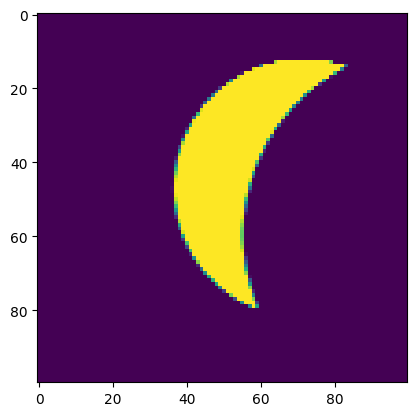

In [31]:
shape = crescent()[2].scale(70).rotate(70).translate(60, 80).fill_color("orange")
plt.imshow(render_line(*shape.get_trace()(P2(0, np.arange(100)), V2(1, 0))))
None

Nice! 10 lines of code and we have a rasterizer. It works
pretty nice off the bat. The main problem though is that
it doesn't yet look as good as Cairo's version. The
textbook issue is that we have *aliasing*. If you zoom
into the edge of our moon you will see jagged little edges.

We'll apply convolution smoothing on each row independently. The idea is to set the value of each pixel based on the surrounding values from the vector diagram. This is a 1D simplification but it makes
the math much easier. The formula is, 

$$I(x) = \int k(u) f(x- u; \theta) du$$

Where $f(x-u)$ is the value of the line our vector image, $k(x)$ is a *kernel*, and $I(x)$ is our
output image. The *kernel* is just a function that weights the contribution of neighbors based on how far
away they are.

We can approximate this integral with Monte-Carlo sampling.

$$ I(x) \approx \frac{1}{N} \sum_i k(u_i) f(x - u_i)  $$

Where $u_i$ are $N$ chosen points around $x$.

We have two choices here: the kernel function and the monte-carlo scheme.

* We'll use a triangle kernel where the weight decays linearly from the center.
* To avoid randomness, we'll always separate
the points in a 1D Line.

From an ML perspective, you can think of this a just applying a 1D convolution to each row of the image with a predefined kernel.


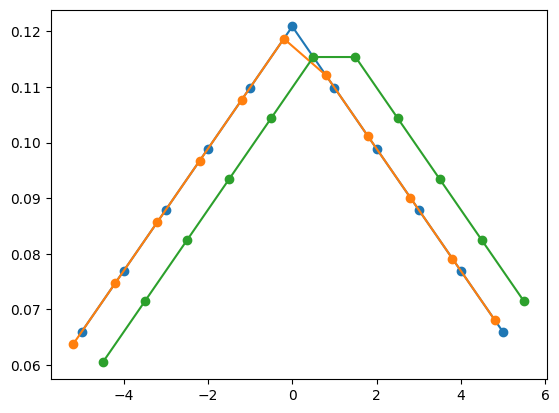

In [32]:
# Kernel width
kern = 11
samples = np.arange(kern) - (kern // 2)


def kernel(offset):
    off_samples = samples - offset
    kernel = kern - np.abs(off_samples)
    return np.maximum(0, kernel / (kern - np.abs(samples)).sum())

# Allow us to offset the grid. 
plt.plot(samples, kernel(0), "o-")
plt.plot(samples - 0.2, kernel(0.2), "o-")
plt.plot(samples + 0.5, kernel(0.5), "o-")

Compare the new image to the original. Note the little "hairs" that come off on both sides. These will become important in the next section. 

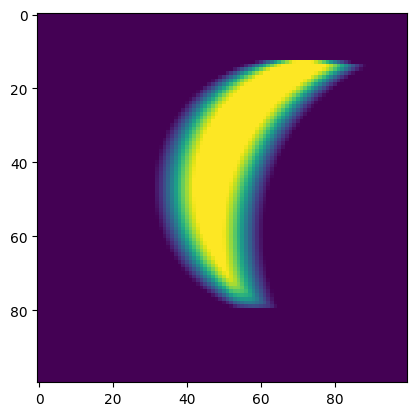

In [33]:
@jax.vmap
def convolve(line):
    k = kernel(0)
    return jax.vmap(lambda s: line[s + samples] @ k)(np.arange(line.shape[0]))


plt.imshow(convolve(render_line(*shape.get_trace()(P2(0, np.arange(100)), V2(1, 0)))))
None

Now let's put everything together. There are three steps.

1. Scan the image.
2. Anti-Alias with a 1D convolution.
3. Compose the image.

We will do it twice once for rows and once for columns.

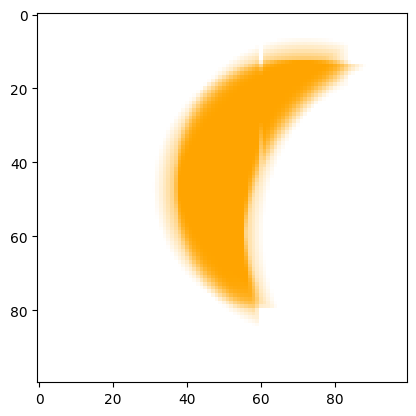

In [34]:
directions = list(map(np.stack, [(V2(0, 1), V2(1, 0)), (V2(1, 0), V2(0, 1))]))

@jax.jit
def render_shape(img, s):
    S = np.arange(SIZE)
    trace = s.get_trace()

    def render(img, d):
        pt, v = d
        # 1. Scan
        raster = render_line(*trace(tx.to_point(pt * S[:, None, None]), v))
        # 2. Apply a 1d conv
        raster = convolve(raster)
        # 3. Compose
        img = (1 - raster[..., None]) * img + raster[..., None] * s.style.fill_color_
        return np.swapaxes(img, 0, 1), raster

    return jax.lax.scan(render, img, directions)


plt.imshow(render_shape(blank, shape)[0])
None

We apply the same process for all the parts of our diagram.



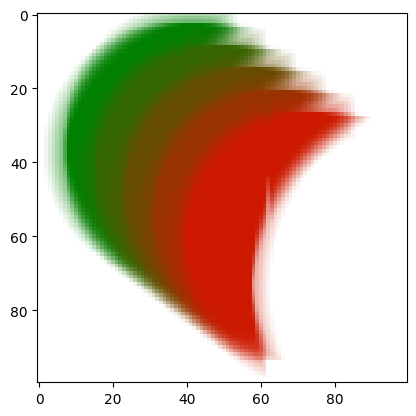

In [35]:
@jax.vmap
def make_shape(i):
    r, g = to_color("red"), to_color("green")
    return shape.translate(-30 + i * 40, -10 + i * 30).fill_color(r * i + g * (1 - i))

def render_shapes(shapes):
    return jax.lax.scan(render_shape, blank, shapes)[0]

plt.imshow(render_shapes(make_shape(np.arange(5) / 5)))
None

And then just a check that we can render for all transforms.



In [36]:
@jax.jit
def im(t):
    s = shape.center_xy().rotate_by(t).translate(50, 50)
    return render_shape(blank, s)[0]


os.system("rm /tmp/test*.png 2> /dev/null")
for t in range(T):
    plt.imshow(im(t / T))
    plt.savefig(f"/tmp/test.{t:02d}.png")
    plt.clf()

animate_out(sorted(glob.glob("/tmp/test.*.png")))

<Figure size 640x480 with 0 Axes>

This rasterizer is fully end-to-end. This now allows use to 
Now we can do our first optimization.We need to specify a goal target image, and then render our
own guess. Here we start with a blue image and target an orange one.
We then optimize through the process (using derivatives) to find the color.


In [37]:
goal = render_shape(blank, shape)[0]

def make_shape(color):
    return shape.fill_color(color)

def loss(x):
    y = render_shape(blank, x)[0]
    return np.pow(y - goal, 2).sum(), ((hgrid + x) | (hgrid + shape)).layout(500)

opt(to_color("blue"), lambda x: loss(make_shape(x)), rate=0.1)

## Section 5: Differentiable Rasterization

In this section we complete the full pipeline, and differentiate through both steps. 

$$\begin{align*}
  \text{vector} &= \text{program}(x) \\
  \text{image} &= \text{rasterizer}(\text{vector}) \\
  {\cal L}(\text{image}, \text{target}) &= \| \text{image} - \text{target} \| \\
\end{align*}$$

In fact, the last example shows we can do this already. We make a vector diagram, rasterize it 
and then just optimize. 

Unfortunately though if the images didn't line up exactly things go wrong. The problem
is that a key step in our rasterization has a derivative of zero.
Take a look at the `render_line` code and see if you can spot it.

In [38]:
new_shape = shape.translate(15, 35)
goal = render_shape(blank, new_shape)[0]


def make_shape(color):
    return shape.fill_color(color)


def loss(x):
    y = render_shape(blank, x)[0]
    return np.pow(y - goal, 2).sum(), ((hgrid + x) | (hgrid + new_shape)).layout(500)


opt(to_color("orange"), lambda x: loss(make_shape(x)), rate=0.1)

The problem is that we are never sending a derivative back through
the `split` variable to the traces, i.e. $\frac{d {\cal L}}{d \ \text{trace}}=0$
That is because the only way split is used is as a discrete index into the
array.

To do step, we are going to have to find a workaround.  

[Differentiable Vector Graphics Rasterization for Editing and Learning](https://cseweb.ucsd.edu/~tzli/diffvg/) describes an elegant method for producing derivatives. We'll use a simplified version here which demonstrates the core idea. 

The trick is to take advantage of the anti-aliasing step. Recall the formula, 

$$I(x) = \int k(u) f(x- u) du$$

We would like to take the derivative of this function with
respect to the trace.

$$\frac{d}{d \ \text{trace}} \int k(u) f(x- u) du$$

But where is the trace in this function? It is used to produce the splits, i.e. the *inside* and *outside* parts where $f$ changes.
We call each of these independent regions $A_i$.

$$\sum_i \frac{d}{d \ \text{trace}} \int_{A_i} f(x-u) k(u) du$$

These intersection points does impact where the *boundary* of the
integral is. To optimize positioning we need a signal from this boundary position.

The methodology for differentiating through integral boundaries is
an identity called [Leibniz's integral rule](https://en.wikipedia.org/wiki/Leibniz_integral_rule).

$$\frac{d}{db} \int_{0}^{b} z(t, b) dt = z(b, b) + \int_{0}^{b} \frac{d z(t, b)}{d b} dt$$

The second part is just within the boundaries. We have taken care of the
already just naturally through our convolution above. This is why the color-match optimization works already. 

The first part though we need to handle ourselves. For our simplified problem this takes a nice form since $z(b, b) = f(x - \text{split})k(\text{split})$. 

$$f(x-\text{split}) k(\text{split}) \approx (f(x-\text{split} + \epsilon) - f(x-\text{split} - \epsilon))k(\text{split})$$

Where the approximation here is necessary because by definition $f(x - \text{split})$ falls directly on a boundary point.
Intuitively the math is just telling us to move boundaries closer/farther to
targets proportional to their kernel value.

Since to implement backprop we need, $$\frac{d L}{d I} \frac{d I}{d \text{trace}}$$ 

The term $\frac{d L}{d I}$ is the size of the image, so the implementation looks like applying the reverse of the triangle kernel from above to each around of the split points to this array. 



In [39]:
@jax.custom_vjp
def boundary(scene, splits, mask):
    "Do nothing on the forward pass."
    return scene


def f_fwd(scene, splits, mask):
    "Blank forward pass."
    return scene, (scene, splits, mask)


def f_bwd(res, g):
    "Backwards pass applies Leibniz."
    f, splits, mask = res
    split_int = np.floor(splits).astype(int)

    def grad_p(s, s_off):
        "Compute the kernel values of neighbors around this point"
        off = s_off - s
        # Chain rule part, g is dL / dI. Apply kernel around split s. 
        v = g[s + samples]
        return (v * (f[s + 1] - f[s - 1])).sum(-1) @ kernel(off)

    # For each split compute dL/dI
    r = jax.vmap(grad_p, in_axes=(-1, -1))(split_int, splits) * mask
    r = np.where(mask.sum() % 2 == 0, r, np.zeros(splits.shape))
    
    return g, -r, None

boundary.defvjp(f_fwd, f_bwd)

We then can apply it on top of our rendering function.
The idea is that this should not change the image in
any way, but it allows us to correct the derivative.


In [40]:
@jax.jit
def boundary_shape(img, s):
    S = np.arange(SIZE)
    trace = s.get_trace()

    def bound(img, d):
        pt, v = d
        s, m = jax.vmap(lambda i: trace(tx.to_point(pt * i), v))(S)
        bound = lambda s, m: jax.vmap(lambda s, m, im: boundary(im, s, m))(s, m, img)
        img = bound(s, m)
        return np.swapaxes(img, 0, 1), None

    return jax.lax.scan(bound, img, directions)[0], None


def boundaries(img, shapes):
    return jax.lax.scan(boundary_shape, img, shapes)[0]

And that's it! We have a differentiable rasterizer. A bit of work, but only really one custom derivative and the rest 
we got from the framework for free. 

### Example 1: Occlusion

This first one shows we can deal with occulusion and multiple shapes for free. 

In [49]:
@jax.vmap
def make_shape1(p):
    loc, color = p
    return (
        shape.center_xy().rotate_by(1 / 4).translate(loc[0], loc[1]).fill_color(color)
    )


# Target vector / raster images
goal_shapes = make_shape1(
    (np.array([[50, 40], [40, 50]]), np.stack([to_color("blue"), to_color("orange")]))
)

# Target vector / raster images
goal_shapes = make_shape1(
    (np.array([[50, 40], [40, 50]]), np.stack([to_color("blue"), to_color("orange")]))
)
goal = render_shapes(goal_shapes)

# Initial parameters $x$
start_param = (
    np.array([[60, 30], [60.0, 60.0]]),
    np.stack([to_color("green"), to_color("green")]),
)


# L2 Loss and draw
def loss(goal, goal_shapes, x):
    y = render_shapes(x)
    y = boundaries(y, x)
    return np.pow(y - goal, 2).sum(), (
        bgrid
        + concat(x).with_envelope(empty())
        + concat(goal_shapes).with_envelope(empty()).fill_opacity(0.2)
    ).layout(500)


opt(
    start_param,
    lambda x: loss(goal, goal_shapes, make_shape1(x)),
    steps=500,
    save_every=5,
    rate=0.1,
)

### Example 2: Paths

This one parameterizes the structure of the arcs that make up the path. 

In [42]:
@jax.vmap
def make_shape2(params):
    s, l, r = params
    s = np.where(np.abs(s) < 1e-3, 1e-3, s)
    part1 = arc_seg(unit_x, s[0])
    part2 = arc_seg(unit_y, s[1])
    part3 = arc_seg(-unit_x, s[2])
    part4 = arc_seg(-unit_y, s[3])
    d = (part1 + part2 + part3 + part4).close().stroke()
    shape = d.scale(12 + r[0]).rotate(70)
    return shape.center_xy().rotate_by(0).translate(50, 30).fill_color("blue")


goal_params = (
    np.array([[0.5, 0.2, 0.7, -0.9]]),
    np.array([[50.0, 30]]),
    np.array([[5.0]]),
)
goal_shapes = make_shape2(goal_params)
goal = render_shapes(goal_shapes)
start_param = (np.array([[-0.5, 0.1, 2, 1]]), np.array([[50.0, 30]]), np.array([[0.0]]))

opt(
    start_param,
    lambda x: loss(goal, goal_shapes, make_shape2(x)),
    steps=1000,
    save_every=5,
    rate=0.01,
)

### Example 3:  Multiple Overlapping Shapes

In this example we create a bunch or red and blue circles with vmap and then try to fill them in.

In [43]:



@jax.vmap
def make_shape3(params, i):
    s, l = params
    s = np.minimum(np.maximum(s, 5.0), 15)
    red, blue = to_color("red"), to_color("blue")
    return (
        circle_at(tx.X.origin, s)
        .translate(l[0], l[1])
        .fill_color(np.where(i % 2, red, blue))
    )



make_shape3 = partial(make_shape3, i=np.arange(10.0))

goal_param = (
    np.array([10 + random.random() for i in range(10)]),
    np.array([20 + random.random() * 50 for i in range(20)]).reshape(10, 2),
)
goal_shapes = make_shape3(goal_param)

make_shape3 = partial(make_shape3, i=np.arange(20))

goal = render_shapes(goal_shapes)
start_param = (
    np.array([10 + random.random() for i in range(20)]),
    np.array([20 + 50 * random.random() for i in range(40)], np.float64).reshape(20, 2),
)


opt(
    start_param,
    lambda x: loss(goal, goal_shapes, make_shape3(x)),
    steps=1000,
    save_every=5,
    rate=0.1,
)

### Example 4:  Shapes with Gaps

In this exmaple we render a star with a gap in the middle to test  the inside/outside aspect of the renderer.

In [44]:
 @jax.vmap
 def star(x):
     sides = 5
     edge = Trail.hrule(1)
     return Trail.concat(
        edge.rotate_by((2 * i) / sides) for i in range(sides)
     ).close().stroke().center_xy().scale(x[0]).rotate(x[1]).translate(x[2], x[3] ).fill_color("orange")
random.seed(1)

start_param = np.array([[65.,random.random(),  40 + i * 20, 40 + 20 * j] for i in range(1) for j in range(1)])
g = np.array([[85., 50, 50 + i * 20, 50 + 20 * j] for i in range(1) for j in range(1)])
goal_shapes = star(g)
goal = render_shapes(star(g))
 
opt(
    start_param,
    lambda x: loss(goal, goal_shapes, star(x)),
    steps=500,
    save_every=2,
    rate=0.35,
    verbose=False,
)

### Example 5:  Multiple Geometric Angles

In this exmaple we render a set of gears that need to fit together.

In [53]:
@jax.vmap
def gear(x):
    sides = 5
    edge = Trail.hrule(1)
    return (
        Trail.concat(edge.rotate_by((i) / sides) for i in range(sides))
        .close()
        .stroke()
        .center_xy()
        .scale(15)
        .rotate_by(x[1])
        .translate(25 + x[2], 25 + x[3])
        .fill_color("orange")
    )

start_param = np.array(
    [
        [15.0, random.random(), 5 + i * 20, 10 + 20 * j]
        for i in range(3)
        for j in range(3)
    ]
)
g = np.array(
    [
        [15.0, random.random(), 1 + i * 20, 1 + 20 * j]
        for i in range(3)
        for j in range(3)
    ]
)
goal_shapes = gear(g)
goal = render_shapes(gear(g))

opt(
    start_param,
    lambda x: loss(goal, goal_shapes, gear(x)),
    steps=500,
    save_every=2,
    rate=0.05
)

### Example 6:  Real Image


All this work brings us to our final goal, rendering an
actual image. Here we take an image from the web and convert
it to an array. Then we start with a bunch of ellipses (scale-transformed circles)
and see how well they can do to approximate it.
Results are pretty neat!


Grab an image from the web and covert to RGB.

In [46]:
png = Image.open("smiley3.webp").convert("RGBA")
background = Image.new("RGBA", png.size, (255, 255, 255))
pic = Image.alpha_composite(background, png)
pic = pic.convert("RGB")
pic = pic.resize((100, 100))
pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3) / 255
# Set background to white for simplicity.
pix = np.where((pix > 0.8).all(-1)[..., None], 1, pix)
pix = np.where((pix < 0.2).all(-1)[..., None], 0, pix)

![](smiley3.webp)


In [47]:
goal = pix

# Draw a bunch of circles.
# Parameterize by scale, translation, and roation.
@jax.vmap
def make_smiley(p):
    s, l, r, c, rot = p
    s = np.where(np.abs(s) < 1e-3, (np.abs(s) / s) * 1e-3, s)
    d = circle_at(P2(0, 0), 1).center_xy()
    r = np.where(np.abs(r) < 1e-3, 0.1, (np.abs(r) / r) * r)
    return (
        d.rotate(rot)
        .scale(1)
        .scale_x((r[0]))
        .scale_y((r[1]))
        .translate(l[0], l[1])
        .fill_color(jax.nn.sigmoid(c))
    )


random.seed(1)

# Draw 20 circles with random starting
# values.
n = 20
start_param = (
    np.zeros((n, 4)) + 0.1,
    np.array(
        [[20 + 60 * random.random(), 20 + 60 * random.random()] for i in range(n)]
    ),
    np.ones((n, 2)) + 2 * np.arange(n + 1, 1, -1)[:, None],
    np.ones((n, 3)),
    np.zeros((n, 1)),
)


# Reduce color precision of the goal slightly.
def reduce(y):
    return np.floor(y * 40) / 40


def loss(goal, x):
    y = render_shapes(x)
    y = boundaries(y, x)
    return np.pow(y - reduce(goal), 2).sum(), None


@jax.jit
def show(x):
    return (bgrid + concat(make_smiley(x)).with_envelope(empty()).line_width(0)).layout(
        500
    )


# Optimize!
opt(
    start_param,
    lambda x: loss(goal, make_smiley(x)),
    show=show,
    steps=1000,
    save_every=10,
    rate=0.1,
)

## Conclusion

So the goal of this post was to understand what differentiable programming 
really look like for challening problems. Of course graphics is a particularly 
nice area for this kind of silliness. 
Since everything has a nice and well-defined mathematical form,
with enough work we can push through the necessary gradients.
We only really had to use one major trick to make derivative 
work, other wise it was just converting if's and for's to 
np.where and vmap.

Still I think this sort of method is still really underexplored 
in other areas. We have really nice tools for writing very complex
programs in a fully vectorized way, and yet we aren't really doing it 
yet as much as feels possible. I hope I can convince you that 
while a little scary, this kind of programming is pretty powerful
and realistically accessible for a lot of different domains. 

-Sasha